In [1]:
#导入包
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, BatchSampler
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torchvision.transforms as transforms
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset, Subset

import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from IPython.display import Image as pyimage
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
from operator import itemgetter
import math
from torchvision.models import resnet101
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
device = 'mps'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("M1 GPU")


Cuda installed! Running on GPU!


数据预处理
确定输入数据

在模型中，我们将图像数据和速度序列一起放入模型中，因此我们需要将这两个部分分开处理。对于每场风暴，我们使用函数来制作序列。在我们的模型中，序列的长度是 11。_get_storm_sequences

同时，我们在函数中处理、裁剪（调整大小）和归一化图像。[3,128,128]__getitem__

模型输入：模型采用两个输入：

x_3d：表示一批图像序列的张量，形状为 。(batch_size, seq_length, C, H, W)
scalar_inputs：表示批处理中每个序列的附加标量输入（风速）的张量，形状为 。(batch_size, scalar_input_size)

In [3]:
class StormDatasetCNNLSTM(Dataset):
    """
   一个数据集类，用于使用CNN-LSTM架构处理风暴图像序列。

参数:
root（str）:数据集的目录路径。
变换（bool）:将预定义变换应用于图像的标志。
sequence length（int）:每个序列中的图像数。
    """

    def __init__(self, root, transform=True, sequence_length=5):
        self.transform = transform
        self.root = root
        self.sequence_length = sequence_length
        self.data = self._get_all_storm_sequences()

    def _get_all_storm_sequences(self):
        """从数据集检索所有风暴序列."""
        return self._get_storm_sequences(self.root)

    def _get_storm_sequences(self, storm_path):
        """获取风暴图像序列及其标签。"""
        paths_labels = self._get_image_paths(storm_path)
        sequences = []
        for i in range(len(paths_labels) - self.sequence_length):
            sequence = [path for path, _, _ in paths_labels[i:i + self.sequence_length]]
            label = paths_labels[i + self.sequence_length - 1][2]
            sequences.append((sequence, label))
        return sequences

    def _get_image_paths(self, storm_path, exts=(".jpg")):
        """检索图像路径及其标签."""
        data = []
        for root, dirs, files in os.walk(storm_path):
            for file in files:
                if file.endswith(exts):
                    img_path = os.path.join(root, file)
                    num_path = img_path.removesuffix('.jpg')
                    try:
                        label_path = num_path + "_label.json"
                        features_path = num_path + "_features.json"
                        time_feature, label = None, None
                        if os.path.exists(features_path) and os.path.exists(label_path):
                            with open(features_path, 'r') as f:
                                features = json.load(f)
                                time_feature = int(features.get('relative_time'))
                            with open(label_path, 'r') as f:
                                label_data = json.load(f)
                                label = int(label_data['wind_speed'])
                            data.append((img_path, time_feature, label))
                    except UnidentifiedImageError:
                        print(f'Image loading error at {img_path}')
                        pass

        data.sort(key=lambda x: x[1])
        return data

    def __getitem__(self, idx):
        """返回单个风暴图像序列及其标签."""
        sequence_paths, final_label = self.data[idx]
        images, labels = [], []

        for img_path in sequence_paths[:-1]:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self._apply_transforms(img)
            images.append(img)

            num_path = img_path.removesuffix('.jpg')
            label_path = num_path + "_label.json"
            with open(label_path, 'r') as f:
                label_data = json.load(f)
                label = int(label_data['wind_speed'])
            labels.append(label)

        labels_tensor = torch.tensor(labels[:-1], dtype=torch.int)

       
        target_img_path = sequence_paths[-1]
        target_img = Image.open(target_img_path).convert('RGB')
        if self.transform:
            target_img = self._apply_transforms(target_img)

        return torch.stack(images), labels_tensor, final_label

    def _apply_transforms(self, img):
        """将预定义的变换应用于图像."""
        transform = transforms.Compose([
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        return transform(img)

    def __len__(self):
        """返回数据集中的样本总数."""
        return len(self.data)

    def __str__(self):
        """返回数据集对象的字符串表示法."""
        class_info = self.__class__.__name__
        class_info += f"\n\tLength: {self.__len__()}"
        for key, value in self.__dict__.items():
            class_info += f"\n\t{key}: {value}"
        return class_info

In [12]:
from torch.utils.data import ConcatDataset, Subset
from torchvision import transforms

def seq_dataset(storm_list, sequence_length=11):
    """
   从风暴列表中创建关联的训练、验证和测试数据集。

参数:
storm_list（str列表）:风暴标识符或路径列表。
sequence length（int）:每个样本的序列长度。

返回情况:
元组:包含串联的训练、测试和验证数据集的元组。
    """
    storm_train_datasets = []
    storm_test_datasets = []
    storm_val_datasets = []

    for storm in storm_list:
        storm_path =  f'storm/{storm}'
        print(storm_path)

        storm_dataset = StormDatasetCNNLSTM(storm_path, sequence_length=sequence_length)

       
        total_size = len(storm_dataset)
        train_size = int(0.8 * total_size)
        val_size = int(0.1 * total_size)
        test_size = total_size - (train_size + val_size)

        train_indices = list(range(0, train_size))
        val_indices = list(range(train_size, train_size + val_size))
        test_indices = list(range(train_size + val_size, total_size))

        train_dataset = Subset(storm_dataset, train_indices)
        val_dataset = Subset(storm_dataset, val_indices)
        test_dataset = Subset(storm_dataset, test_indices)

        print(len(train_dataset), len(val_dataset), len(test_dataset))

        storm_train_datasets.append(train_dataset)
        storm_val_datasets.append(val_dataset)
        storm_test_datasets.append(test_dataset)

    return ConcatDataset(storm_train_datasets), ConcatDataset(storm_val_datasets), ConcatDataset(storm_test_datasets)

In [13]:
storm_list = ['hig', 'gme', 'woc', 'blq', 'kqu', 'wsy',
              'ipa', 'ztb', 'gkf', 'qpq', 'pjj', 'rml',
              'xjo', 'vxf', 'fgi', 'fna', 'ing', 'yfn',
              'ywf', 'mtw', 'eoi', 'sxb', 'vye', 'zny',
              'psz', 'pvj', 'dzw', 'ojv']

train_dataset, test_dataset, val_dataset = seq_dataset(storm_list = storm_list)

storm/hig
264 33 34
storm/gme
158 19 21
storm/woc
129 16 17
storm/blq
81 10 11
storm/kqu
237 29 31
storm/wsy
372 46 48
storm/ipa
350 43 45
storm/ztb
197 24 26
storm/gkf
263 32 34
storm/qpq
198 24 26
storm/pjj
179 22 23
storm/rml
203 25 26
storm/xjo
244 30 32
storm/vxf
172 21 23
storm/fgi
190 23 25
storm/fna
252 31 32
storm/ing
389 48 50
storm/yfn
136 17 17
storm/ywf
115 14 15
storm/mtw
271 33 35
storm/eoi
381 47 49
storm/sxb
185 23 24
storm/vye
190 23 25
storm/zny
312 39 40
storm/psz
294 36 38
storm/pvj
176 22 23
storm/dzw
284 35 37
storm/ojv
327 40 42


In [14]:
print(train_dataset.__len__())

6549


In [15]:
class CNNLSTM(nn.Module):
    """
    用于处理具有额外纯量输入的图像序列的CNN-LSTM模型。

    该模型结合了卷积层，用于从图像中提取空间特征
    以及LSTM层，用于捕获提取的特征序列中的时间依赖性。
    它非常适合视频分类或时间序列预测等任务，
    每个时间步都涉及图像数据。

    参数：
    - hidden_size（int）：LSTM隐藏状态下的要素数量。
    - num_layers（int）：LSTM中循环层的数量。
    - scalar_entry_size（int）：额外纯量输入的大小。
    """

    def __init__(self, hidden_size=256, num_layers=5, scalar_input_size=9):
        super(CNNLSTM, self).__init__()

        # 定义用于空间特征提取的CNN层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 动态计算LSTM输入特征的大小
        lstm_input_size = 32 * 32 * 32

        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=num_layers)

        # 结合了来自LSTM和其它标量输入的功能
        self.fc1 = nn.Linear(hidden_size + scalar_input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x_3d, scalar_inputs):
        """
       CNN-LSTM模型的前传。

        Args:
        - x_3d (torch.Tensor): 包含一组图像序列的输入张量。
                               Shape: （批量大小，分段长度，C，H，W）
        - scalar_inputs (torch.Tensor): 每个序列的额外标量输入。
                                        Shape: (批量大小，标量输入大小）

        Returns:
        - torch.Tensor: 模型的输出预测。
        """
        hidden = None
        batch_size, seq_length, _, _, _ = x_3d.size()

        for t in range(seq_length):
            x = F.relu(self.conv1(x_3d[:, t, :, :, :]))
            x = self.pool(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = x.view(batch_size, -1)
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # 将LST输出与标量输入相结合
        combined = torch.cat((out[-1, :, :], scalar_inputs), dim=1)

        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x


In [16]:
from torch import nn, optim
import torch
from tqdm import tqdm

# 将标准定义为回归任务的根平均平方误差损失

def rmse_loss(output, target):
    """
    计算输出张量和目标张量之间的根平均平方误差.

    Args:
        output (torch.Tensor)
        target (torch.Tensor)

    Returns:
        torch.Tensor: RMSE 缺失值
    """
    return torch.sqrt(nn.MSELoss()(output, target))

def train(model, optimizer, criterion, data_loader, device):
   
    model.train()
    train_loss = 0

    for X, W, y in tqdm(data_loader):
        X, W, y = X.to(device), W.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(X.view(-1, 10, 3, 128, 128), W.view(-1, 9)).squeeze()
        y = y.float()
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)

    return train_loss / len(data_loader.dataset)

def validate(model, criterion, data_loader, device):
   
    model.eval()
    validation_loss = 0

    with torch.no_grad():
        for X, W, y in data_loader:
            X, W, y = X.to(device), W.to(device), y.to(device)
            output = model(X.view(-1, 10, 3, 128, 128), W.view(-1, 9)).squeeze()
            y = y.float()
            loss = criterion(output, y)

            validation_loss += loss.item() * X.size(0)

    return validation_loss / len(data_loader.dataset)


In [19]:
batch_size = 16
test_batch_size = 32
n_epochs = 1

In [22]:
def train_model(n_epochs):
    """
    使用固定种子值训练CNN-LSTM模型，使用L1 Loss和Adam优化器。

    Args:
        n_epochs (int): 训练的总epoch次数。

    Returns:
        model: 训练好的模型。
        train_loss_list (list): 每个epoch的训练损失列表。
        val_loss_list (list): 每个epoch的验证损失列表。
    """
    model = CNNLSTM().to(device)
    set_seed(20)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    train_loss_list = []
    val_loss_list = []

    for epoch in range(n_epochs):
        # 训练
        train_loss = train(model, optimizer, criterion, train_loader, device=device)
        train_loss_list.append(train_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}')

        # 验证
        val_loss = validate(model, criterion, validation_loader, device=device)
        val_loss_list.append(val_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss}')

    return model, train_loss_list, val_loss_list

# 使用示例
n_epochs = 10  # 自定义 epoch 次数
model, train_loss_list, val_loss_list = train_model(n_epochs)


100%|██████████| 410/410 [01:21<00:00,  5.02it/s]


Epoch 1/10, Train Loss: 5.54706973981486
Epoch 1/10, Validation Loss: 2.764340078311197


100%|██████████| 410/410 [01:33<00:00,  4.37it/s]


Epoch 2/10, Train Loss: 2.0241285320237714
Epoch 2/10, Validation Loss: 2.0103720975568073


100%|██████████| 410/410 [01:27<00:00,  4.67it/s]


Epoch 3/10, Train Loss: 1.7292126492883144
Epoch 3/10, Validation Loss: 1.2890228523101628


100%|██████████| 410/410 [01:25<00:00,  4.82it/s]


Epoch 4/10, Train Loss: 1.421256914213789
Epoch 4/10, Validation Loss: 1.0619717673502767


100%|██████████| 410/410 [01:26<00:00,  4.76it/s]


Epoch 5/10, Train Loss: 1.1105433286901902
Epoch 5/10, Validation Loss: 1.1179361982255718


100%|██████████| 410/410 [01:20<00:00,  5.09it/s]


Epoch 6/10, Train Loss: 0.8800112193942088
Epoch 6/10, Validation Loss: 0.7211438105019299


100%|██████████| 410/410 [01:23<00:00,  4.91it/s]


Epoch 7/10, Train Loss: 0.7855583166854039
Epoch 7/10, Validation Loss: 0.6426286257197916


100%|██████████| 410/410 [01:16<00:00,  5.39it/s]


Epoch 8/10, Train Loss: 0.7856116642167794
Epoch 8/10, Validation Loss: 0.8706876778069037


100%|██████████| 410/410 [01:19<00:00,  5.17it/s]


Epoch 9/10, Train Loss: 0.7421448719576126
Epoch 9/10, Validation Loss: 0.7715755573992735


100%|██████████| 410/410 [01:20<00:00,  5.12it/s]


Epoch 10/10, Train Loss: 0.7848262204516296
Epoch 10/10, Validation Loss: 0.5457364561560578


In [26]:
torch.save(model.state_dict(), 'task2_model.pth')

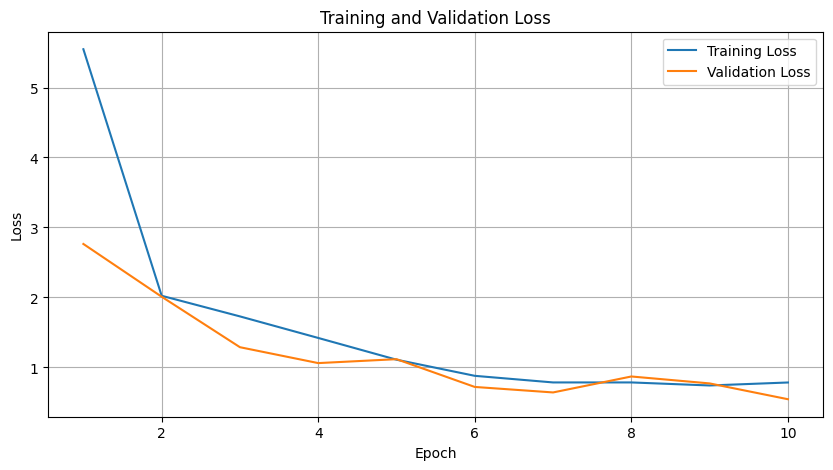

In [28]:
import matplotlib.pyplot as plt

def plot_loss(train_loss_list, val_loss_list):
    """
    绘制训练损失和验证损失随着epoch的变化图表。

    Args:
        train_loss_list (list): 每个epoch的训练损失列表。
        val_loss_list (list): 每个epoch的验证损失列表。
    """
    epochs = range(1, len(train_loss_list) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用示例
plot_loss(train_loss_list, val_loss_list)


In [29]:
loaded_model = CNNLSTM()
loaded_model.load_state_dict(torch.load('task2_model.pth'))

<All keys matched successfully>

In [31]:
loaded_model =loaded_model.to(device)

predictions = []
real = []
for i in range(len(test_dataset)):
  x = test_dataset[i][0]
  x = x.view(-1, 10, 3, 128, 128).to(device)
  w = test_dataset[i][1].view(1,9).to(device)
  pr = loaded_model(x, w).squeeze().item()
  r = test_dataset[i][2]
  predictions.append(pr)
  real.append(r)

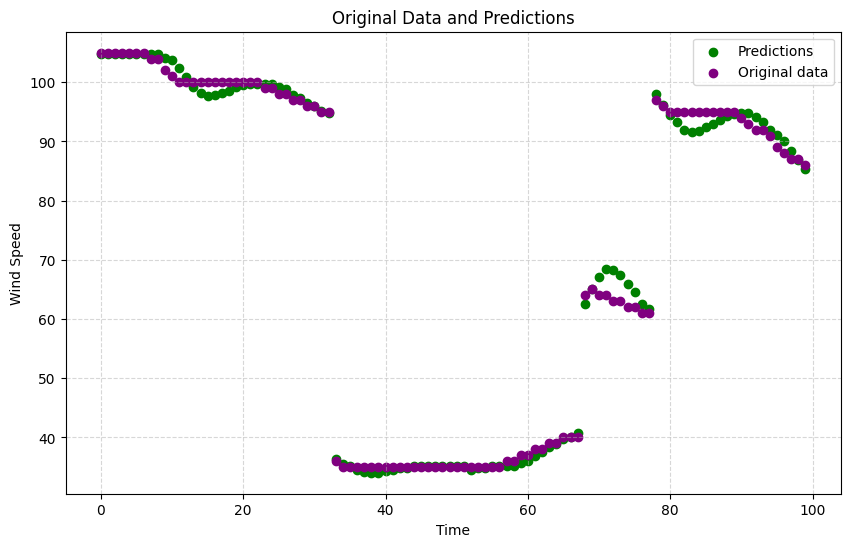

In [32]:
import numpy as np

space = np.arange(0,100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(space, predictions[0:100], color='green', marker='o', linestyle='-', label='Predictions')
ax.scatter(space, real[0:100], color='purple', marker='o', linestyle='-', label='Original data')

ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)

ax.set_title('Original Data and Predictions')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed')


plt.show()


In [104]:
class Storm_Dataset(Dataset):
    """
    A custom dataset class for loading image data along with their associated
    labels and features.

    This class is designed to load data from a specified directory, handling
    images and their associated
    label and feature files. It splits the data into training and test sets
    and supports basic transformations.

    Attributes:
        root (str): The root directory from which the data is loaded.
        data (list): List of tuples containing paths to images and their
        associated labels and features.
        train_data (list): List of training data samples.
        test_data (list): List of test data samples.

    Args:
        root (str): The directory path from where to load the data.
        test_size (float, optional): Proportion of the dataset to include in
        the test split. Defaults to 0.2.
        seed (int, optional): Random seed for splitting the dataset.
        Defaults to 42.
    """

    def __init__(self, root,
                 test_size=0.2, seed=42, split_method='random', split='none'):
        self.root = root
        all_data = self._get_image_paths()
        self.data = all_data
        # Splitting the dataset into training and testing
        # Also allows for no split for data analysis
        if split_method == 'random':
            train, test = train_test_split(
                all_data, test_size=test_size, random_state=seed)
            if split == 'train':
                self.data = train
            elif split == 'test':
                self.data = test
        elif split_method == 'time':
            split_index = math.floor(self.__len__() * 0.7)
            train = self.data[:split_index]
            test = self.data[split_index:]
            if split == 'train':
                self.data = train
            elif split == 'test':
                self.data = test

    def _get_image_paths(self, exts=(".jpg")):
        """
        Private method to scan the directory and gather image paths along with
        their label and feature data.

        This method walks through the directory, finds images with specified
        extensions, and attempts to locate corresponding label and feature
        files. It handles basic exceptions related to image loading.

        Args:
            exts (tuple of str, optional): File extensions to consider for
            images. Defaults to (".jpg").

        Returns:
            list: A list of tuples, each containing paths to an image, its
            label, and features.
        """
        data = []
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(exts):
                    path = os.path.join(root, file)
                    num_path = path.removesuffix('.jpg')

                    try:
                        label_path = num_path + "_label.json"
                        features_path = num_path + "_features.json"
                        label, storm_id, time, ocean = None, None, None, None
                        if os.path.exists(label_path):
                            with open(label_path, 'r') as f:
                                label_data = json.load(f)
                                label = int(label_data['wind_speed'])

                        if os.path.exists(features_path):
                            with open(features_path, 'r') as f:
                                features_data = json.load(f)
                                storm_id = features_data['storm_id']
                                time = int(features_data['relative_time'])
                                ocean = int(features_data['ocean'])

                        data.append((path, label, storm_id, time, ocean))
                    except UnidentifiedImageError:
                        print('image error')
                        pass
        data.sort(key=itemgetter(3))
        return data

    def __getitem__(self, idx):
        """
        Returns a single data sample at the specified index.

        This method reads the image from the disk, applies transformations if
        required, and returns it along with its label and features.

        Args:
            idx (int): The index of the data sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image, label, and
            features of the sample.
        """
        img_path, label,  storm_id, time, ocean = self.data[idx]
        img = Image.open(img_path)
        img = img.convert('L')
        img = ToTensor()(img)
        img = Resize((256,256))(img)
        return img, label

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)

    def __str__(self):
        """
        Returns a string representation of the dataset object.

        Provides a summary of the dataset including its length and other
        attributes except the raw data.

        Returns:
            str: A string summarizing the dataset.
        """
        class_string = self.__class__.__name__
        class_string += f"\n\tlen : {self.__len__()}"
        for key, value in self.__dict__.items():
            if key != "data":
                class_string += f"\n\t{key} : {value}"
        return class_string

In [105]:
class ImageRegressionCNN(nn.Module):
    def __init__(self):
        super(ImageRegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.LeakyReLU(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.LeakyReLU(0.2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        # Calculate the correct input size
        self.fc1_input_size = 64 * 64 * 64
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.act2(self.conv2_5(x))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.flatten(x)
        x = self.act2(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(self.act3(x))
        return x

In [176]:
storm_list=['hig', 'gme', 'woc', 'blq', 'kqu', 'wsy', 'ipa', 'ztb', 'qpq', 'pjj']

In [177]:
import StormForcast

In [178]:
cnn_model = StormForcast.Train_Validate('storm', task='WindSpeed', device='cuda',
                                        batch_size_train=32, batch_size_val=1000, batch_size_test=1000,
                                        lr=2e-3, epoch=30, split_method='random', num_storms=10)

setting basic parameters ......
done
setting hyperparameters ......
done
initializing model, optimier, criterion ......
done
loading data ......


Loading Data:  93%|█████████▎| 2823/3050 [00:00<00:00, 18229.42it/s]


done


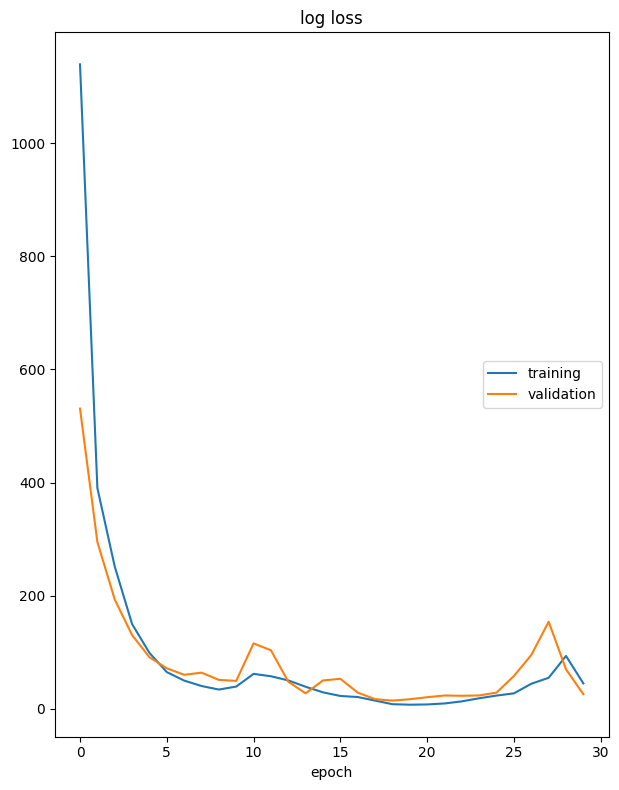

log loss
	training         	 (min:    7.182, max: 1139.341, cur:   44.772)
	validation       	 (min:   14.433, max:  530.649, cur:   25.653)


In [179]:
cnn_model.train_whole()

In [164]:
torch.save({'model_state_dict': cnn_model.model.state_dict(),
            'optimizer_state_dict': cnn_model.optimizer.state_dict(),
            }, 'general_model.pth')

In [ ]:
surprise_model = StormForcast.Train_Validate('./tst/tst', task='WindSpeed', device='cuda',
                                        batch_size_train=135, batch_size_val=100, batch_size_test=100,
                                        lr=2e-11, epoch=30, weight_decay=1e-1, split_method='random', num_storms=1, surprise_storm=True,
                                    resume=True, resume_path='CNNGeneral_epoch_11__2024-06-07_22-30-41.pth')
surprise_model.draw_result(type='predict')
surprise_model.predict()